# MNIST-Adversary

## Work In Progress

Trying to replicate results from [this paper by Papernot et al.](https://arxiv.org/abs/1602.02697)

___

In lieu of using the ML APIs like the paper, I'm using a pretrained model provided by the [PyTorch Playground](https://github.com/aaron-xichen/pytorch-playground).

My original hope was to have no knowledge of the architecture, but that was dashed when it printed to std. out... Still, the playground uses a totally DNN architecture, whereas my replicated model is CNN-based.

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from utee import selector
from PIL import Image, ImageOps
from os.path import expanduser, join
from subprocess import call
import random

# From pytorch-playground example
model_raw, ds_fetcher, is_imagenet = selector.select('mnist')
model_raw.eval()

ds_val = ds_fetcher(batch_size=10, train=False, val=True)

act = np.empty([0,1], dtype='int64')
pred = np.empty([0,1], dtype='int64')

# From pytorch-playground example, modified
for idx, (data, target) in enumerate(ds_val):
    data =  Variable(torch.FloatTensor(data)).cuda()
    output = model_raw(data)
    act = np.append(act, target.numpy())
    pred = np.append(pred, output.data.cpu().numpy().argmax(axis=1)) # read to numpy for use in a DF
    
model_fit = pd.DataFrame(np.column_stack([act, pred]), columns = ['act','pred'])
model_fit['correct'] = model_fit.act==model_fit.pred
model_fit.head()

Building and initializing mnist parameters
Sequential(
  (fc1): Linear(in_features=784, out_features=256)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2)
  (fc2): Linear(in_features=256, out_features=256)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2)
  (out): Linear(in_features=256, out_features=10)
)


Building MNIST data loader with 1 workers


,act,pred,correct
0,3,3,True
1,4,4,True
2,4,4,True
3,7,7,True
4,1,1,True


In [2]:
# Summary stats
print("Overall model accuracy: {:.2f}%".format(100*model_fit.correct.mean()))
print("\nModel accuracy by number:")
print(model_fit.groupby('act', as_index=False).correct.mean().apply(lambda row: ": {:.2f}%".format(100*row['correct']), axis=1))

Overall model accuracy: 98.42%

Model accuracy by number:
0    : 99.08%
1    : 99.21%
2    : 98.55%
3    : 98.22%
4    : 98.57%
5    : 98.09%
6    : 98.75%
7    : 97.76%
8    : 97.64%
9    : 98.22%
dtype: object


Rather than create my own dataset of handwritten digits, I'm going to use the handwritten portion of the [Char74K](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/) dataset.

The below will extract it into your current folder.

The images are 1-indexed, 0-9; so while the filenames will still be n+1, this will put the images in the correct class folder.

Additionally, this block will select a random 10 images from each class, in keeping with Papernot's methodology.

In [3]:
random.seed(1234)

# get the data
curr = os.getcwd()
home = expanduser("~")
dl_loc = join(home,"downloads/char76k")

call(["mkdir","-p",dl_loc])
os.chdir(dl_loc)

call(["wget","http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishHnd.tgz"])
call(["tar","-xvzf", "EnglishHnd.tgz"])

os.chdir(curr)
for i in range(10):
    new_folder = "./data/{}".format(i)
    call(["mkdir","-p", new_folder])
    digit_folder = join(dl_loc, "English/Hnd/Img/Sample{:03d}/".format(i+1))
    samples = random.sample(os.listdir(digit_folder),10)
    for sample in samples:
        call(['cp', join(digit_folder, sample), new_folder])

(1200, 900)


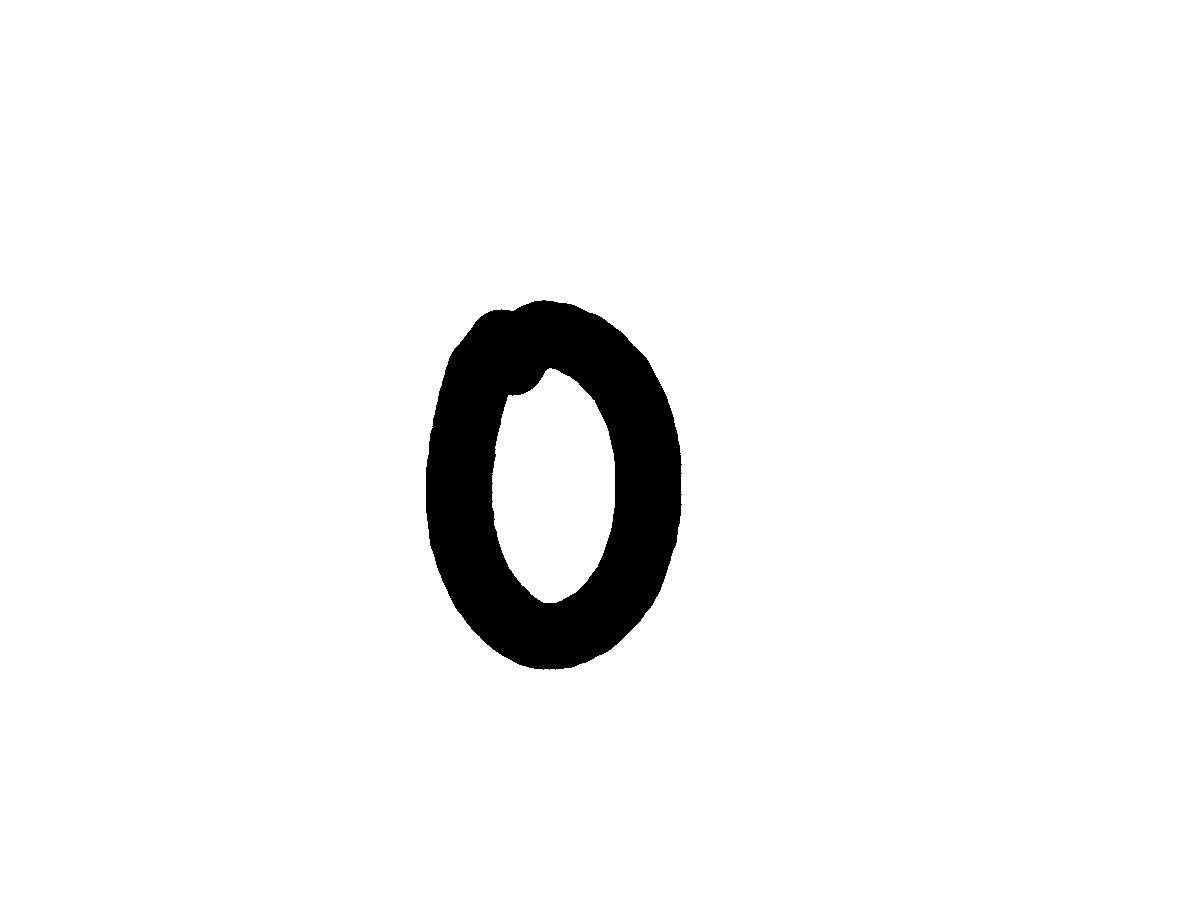

In [4]:
img_file = join('./data/0/', os.listdir('./data/0/')[0])
img = Image.open(img_file)
print(img.size)
img

Little big... and the colors are reversed. Let's invert and shrink it

In [5]:
img = ImageOps.invert(img) # Invert black and white
img.thumbnail((28, 28), Image.ANTIALIAS) # shrinking down to 28*28
img

That looks much better... Now let's do the same with PyTorch

In [6]:
img = Image.open(img_file)

digit_transform = transforms.Compose([
            lambda x: ImageOps.invert(x),
            transforms.CenterCrop(700), # I was getting squished images. CenterCroping makes it square
            transforms.Resize((28,28), Image.ANTIALIAS),
            transforms.Grayscale(1),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)), # Technically cheating, but we can assume the victim would do this
        ])

to_img = transforms.ToPILImage()
print(digit_transform(img).shape)
img_t = to_img(digit_transform(img))
img_t

torch.Size([1, 28, 28])


Set up an ImageFolder and Dataset. Leveraging code from [this gist](https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb) for adding in the train/test split for random sampling

In [7]:
im_folder = datasets.ImageFolder('./data/', transform=digit_transform)

im_loader = torch.utils.data.DataLoader(im_folder, 
                    batch_size=10,
                    num_workers=4,
                    shuffle=True)

In [8]:
victim_pred = []
correct = 0

for batch, (data, target) in enumerate(im_loader):

    data, target = Variable(data.cuda(), volatile=True), Variable(target.cuda())
    
    output = model_raw(data)
    pred = output.data.max(1, keepdim=True)[1] # same as argmax
    
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    victim_pred.append(pred) # collect predicted class for oracle
    
print("Black Box Model {:0.0f}% accurate on new data".format(correct/len(im_folder)*100))

Black Box Model 49% accurate on new data


49% isn't great, so this dataset may be too different from MNIST digits.

*self: Add in the 150 MNIST test images like the paper, and use open-cv to create your own "hand-written" images*

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 32, kernel_size=5) # I originally tried fewer filters, but these are closer to the paper
        self.fc1 = nn.Linear(512, 20)
        self.fc2 = nn.Linear(20, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
oracle = Net()
oracle.cuda()

optimizer = optim.Adam(oracle.parameters(), lr=0.05) #tune up LR

In [11]:
# Forward pass noise to ensure the dimensions are right
oracle(Variable(torch.rand([1,1,28,28]).cuda()))

Variable containing:
    0     0     0     0     0     0     0     0     1     0
[torch.cuda.FloatTensor of size 1x10 (GPU 0)]

In [15]:
def train(epoch):
    correct = 0
    oracle.train()
    for batch, (data, t) in enumerate(im_loader):       
        t = t.cuda()
        t = Variable(t)
        data = data.cuda()
        data = Variable(data)
        
        bb_out = model_raw(data)
        target = Variable(bb_out.data.max(1, keepdim=True)[1]).view(10,)
        
        optimizer.zero_grad()
        output = oracle(data)
        
        pred = output.data.max(1, keepdim=True)[1] # same as argmax
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch % 9 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch * len(data), len(im_loader.dataset),
                100. * batch / len(im_loader), loss.data[0]))
            
    print("Oracle {:0.0f}% accurate on black box".format(correct/len(im_folder)*100))
    
for i in range(10):
    train(i)

Train Epoch: 0 [0/100 (0%)]	Loss: -0.103566
Train Epoch: 0 [90/100 (90%)]	Loss: -0.300000
Oracle 17% accurate on black box
Train Epoch: 1 [0/100 (0%)]	Loss: -0.200000
Train Epoch: 1 [90/100 (90%)]	Loss: -0.100000
Oracle 17% accurate on black box
Train Epoch: 2 [0/100 (0%)]	Loss: -0.200000
Train Epoch: 2 [90/100 (90%)]	Loss: -0.200000
Oracle 17% accurate on black box
Train Epoch: 3 [0/100 (0%)]	Loss: -0.200000
Train Epoch: 3 [90/100 (90%)]	Loss: -0.100000
Oracle 17% accurate on black box
Train Epoch: 4 [0/100 (0%)]	Loss: -0.200000
Train Epoch: 4 [90/100 (90%)]	Loss: 0.000000
Oracle 17% accurate on black box
Train Epoch: 5 [0/100 (0%)]	Loss: -0.200000
Train Epoch: 5 [90/100 (90%)]	Loss: -0.100000
Oracle 17% accurate on black box
Train Epoch: 6 [0/100 (0%)]	Loss: -0.400000
Train Epoch: 6 [90/100 (90%)]	Loss: -0.100000
Oracle 17% accurate on black box
Train Epoch: 7 [0/100 (0%)]	Loss: -0.100000
Train Epoch: 7 [90/100 (90%)]	Loss: -0.200000
Oracle 17% accurate on black box
Train Epoch: 8 [0

*self: debug, oracle doesn't seem to be learning*